# Importing required libraries and packages

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import xgboost as xgb
import warnings

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, precision_score, accuracy_score, recall_score, balanced_accuracy_score
from sklearn.metrics import classification_report, RocCurveDisplay, roc_curve, confusion_matrix, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline

warnings.filterwarnings('ignore')

## Importing the dataset

In [ ]:
## Importing the data
from google.colab import files
uploaded = files.upload()

Saving UCIBankingPreprocessedData.csv to UCIBankingPreprocessedData.csv


In [ ]:
import io
df = pd.read_csv(io.BytesIO(uploaded['UCIBankingPreprocessedData.csv']))

## Problem Statement

This project aims to create a predictive model to assist a Portuguese banking institution in optimizing its direct marketing campaigns. The objective is to predict whether a client will subscribe to a term deposit ("yes" or "no") based on relevant client and campaign-related features. The model will enhance campaign efficiency and success by targeting potential subscribers more effectively.

In [ ]:
df.head()

,Unnamed: 0,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0,40,4,1,2,0,3036,1,0,1,4,8,261,0,0,0,1,0
1,1,26,9,2,1,0,945,1,0,1,4,8,151,0,0,0,1,0
2,2,15,2,1,1,0,918,1,1,1,4,8,76,0,0,0,1,0
3,3,29,1,1,3,0,2420,1,0,1,4,8,92,0,0,0,1,0
4,4,15,11,2,3,0,917,0,0,1,4,8,198,0,0,0,1,0


In [ ]:
df = df.drop(df.columns[0], axis=1)

In [ ]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,40,4,1,2,0,3036,1,0,1,4,8,261,0,0,0,1,0
1,26,9,2,1,0,945,1,0,1,4,8,151,0,0,0,1,0
2,15,2,1,1,0,918,1,1,1,4,8,76,0,0,0,1,0
3,29,1,1,3,0,2420,1,0,1,4,8,92,0,0,0,1,0
4,15,11,2,3,0,917,0,0,1,4,8,198,0,0,0,1,0


<Axes: >

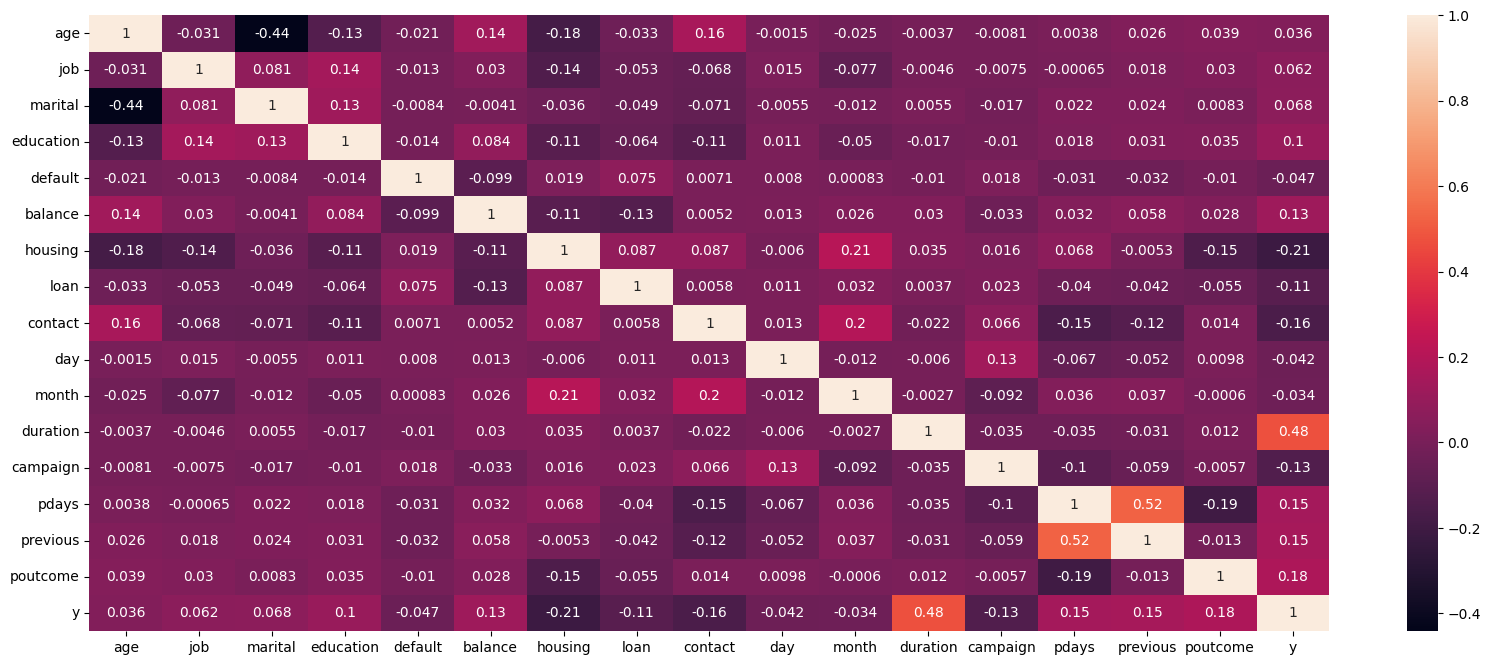

In [ ]:
plt.figure(figsize=(20,8))
sns.heatmap(df.corr(),annot =True)

In [ ]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

In [ ]:
X = df.drop([ 'contact', 'day', 'month','y'],axis =1)

In [ ]:
y=df['y']

## Splitting the dataset into training and test dataset with a distribution of 70% for training and 30% for prediction

In [ ]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test

# Scaling the Balance and Duration values

In [ ]:
st = StandardScaler()

X_train['balance'] = st.fit_transform(X_train[['balance']])
X_test['balance'] = st.transform(X_test[['balance']])

X_train['duration'] = st.fit_transform(X_train[['duration']])
X_test['duration'] = st.transform(X_test[['duration']])


# GridSearchCV and Hyperparameter Tuning

In [ ]:
def train_and_evaluate_model(model_name, X_train, y_train, X_test, y_test):
    # Define models and their respective parameter grids

    models = {
    'KNN': (KNeighborsClassifier(), {
        'classifier__n_neighbors': [3, 5, 7],
        'classifier__weights': ['uniform', 'distance'],
        'classifier__algorithm': ['auto', 'ball_tree', 'kd_tree'],
    }),
    'Logistic Regression': (LogisticRegression(), {
        'classifier__C': [0.1, 1, 10],
        'classifier__penalty': ['l1', 'l2'],
        'classifier__solver': ['newton-cg', 'lbfgs', 'liblinear'],
    }),
    'Decision Tree': (DecisionTreeClassifier(), {
        'classifier__max_depth': [None, 10, 20, 30],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4],
    }),
    'Random Forest': (RandomForestClassifier(), {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [None, 10, 20, 30],
        'classifier__min_samples_split': [2, 5, 10],
    }),
    'XGBoost': (XGBClassifier(), {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__learning_rate': [0.1, 0.01, 0.001],
        'classifier__max_depth': [3, 6, 9],
    })
}



    if model_name not in models:
        print(f"Model '{model_name}' not supported.")
        return

    model, param_grid = models[model_name]

    # Create a pipeline with standard scaling and the model
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', model)
    ])

    # Perform hyperparameter tuning using GridSearchCV
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = grid_search.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

     # Calculate the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Print the confusion matrix
    print("Confusion Matrix:")
    print(conf_matrix)

    # Compute ROC and AUC
    y_prob = grid_search.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')

    # Print the evaluation metrics
    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"F1 Score: {f1:.2f}")

    ### List the best parameter out of the given set of parameters
    print(f"Best Parameters: {grid_search.best_params_}")

    plt.show()


# Logistic Regression with hyperparameter tuning and GridSearchCV

Confusion Matrix:
[[9900 2125]
 [2628 9301]]
Model: Logistic Regression
Accuracy: 0.80
Recall: 0.78
Precision: 0.81
F1 Score: 0.80
Best Parameters: {'classifier__C': 1, 'classifier__penalty': 'l2', 'classifier__solver': 'newton-cg'}


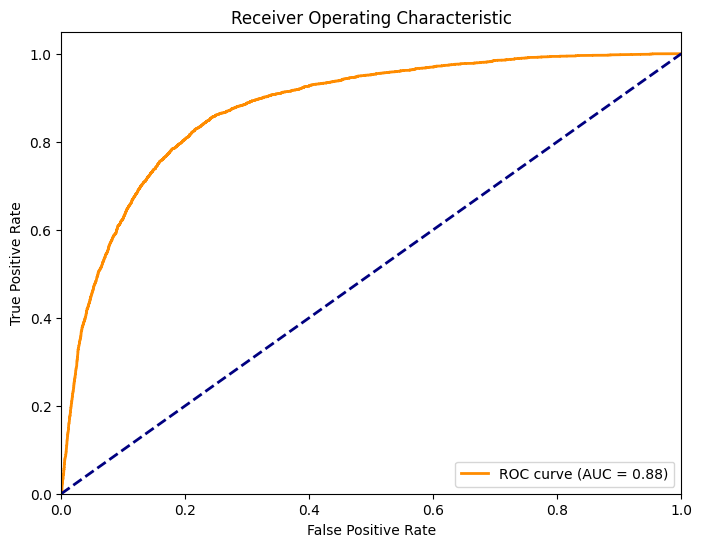

In [ ]:
train_and_evaluate_model('Logistic Regression', X_train, y_train, X_test, y_test)


# KNN with hyperparameter tuning and GridSearchCV

Confusion Matrix:
[[10177  1848]
 [   27 11902]]
Model: KNN
Accuracy: 0.92
Recall: 1.00
Precision: 0.87
F1 Score: 0.93
Best Parameters: {'classifier__algorithm': 'auto', 'classifier__n_neighbors': 3, 'classifier__weights': 'distance'}


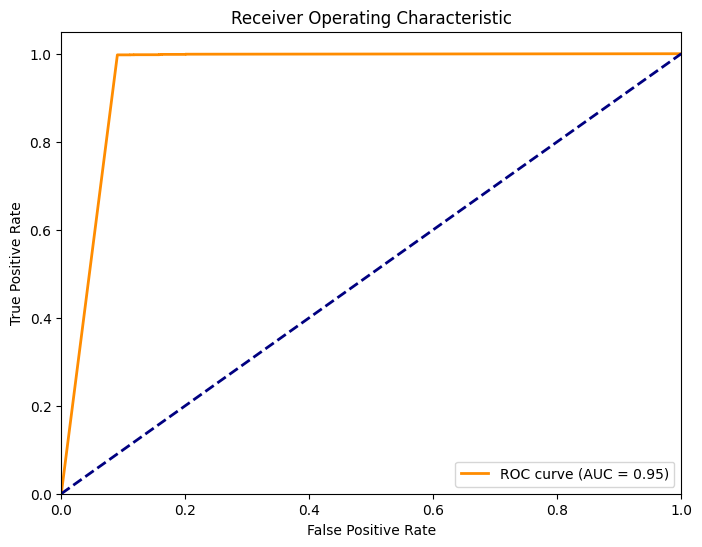

In [ ]:
train_and_evaluate_model('KNN', X_train, y_train, X_test, y_test)


# Decision Tree with hyperparameter tuning and GridSearchCV

Confusion Matrix:
[[10837  1188]
 [   27 11902]]
Model: Decision Tree
Accuracy: 0.95
Recall: 1.00
Precision: 0.91
F1 Score: 0.95
Best Parameters: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}


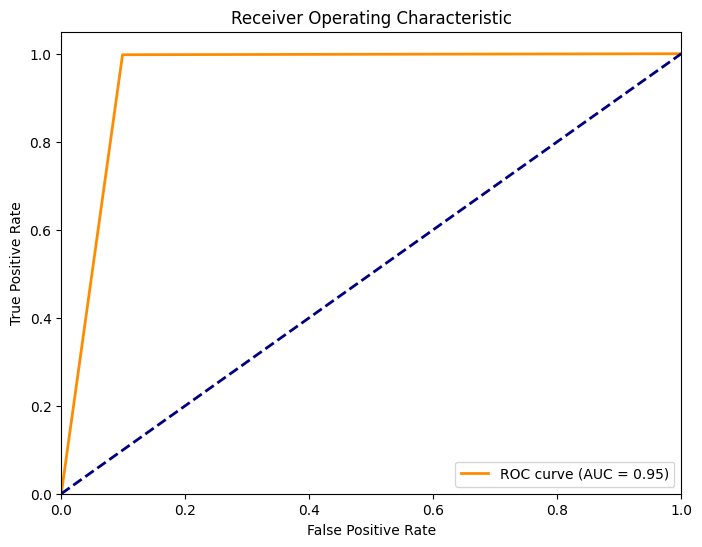

In [ ]:
train_and_evaluate_model('Decision Tree', X_train, y_train, X_test, y_test)


# Random Forest with hyperparameter tuning and GridSearchCV

Confusion Matrix:
[[11139   886]
 [   22 11907]]
Model: Random Forest
Accuracy: 0.96
Recall: 1.00
Precision: 0.93
F1 Score: 0.96
Best Parameters: {'classifier__max_depth': None, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 50}


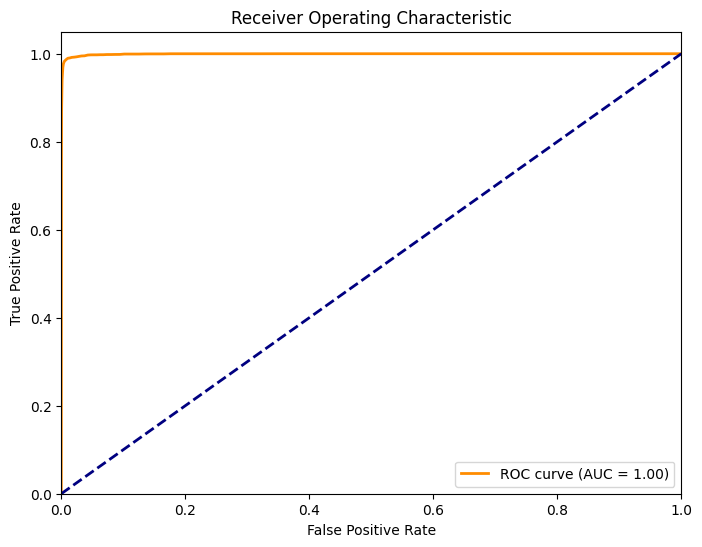

In [ ]:
train_and_evaluate_model('Random Forest', X_train, y_train, X_test, y_test)


# XGBoost with hyperparameter tuning and GridSearchCV

Confusion Matrix:
[[10388  1637]
 [  558 11371]]
Model: XGBoost
Accuracy: 0.91
Recall: 0.95
Precision: 0.87
F1 Score: 0.91
Best Parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 9, 'classifier__n_estimators': 200}


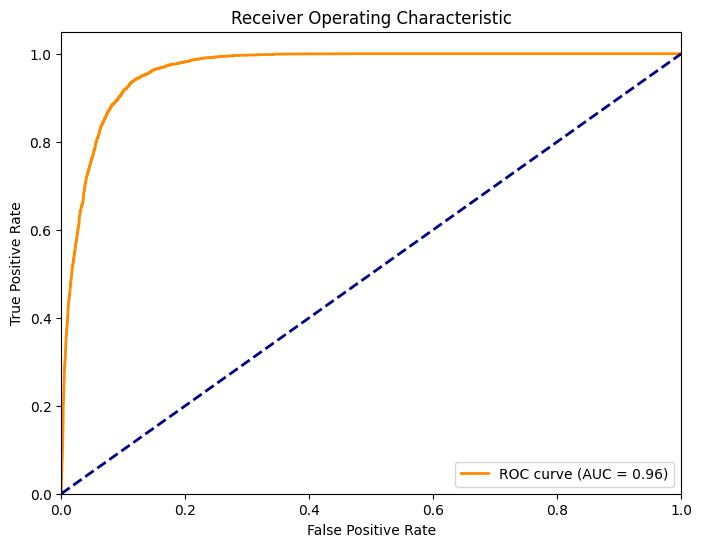

In [ ]:
train_and_evaluate_model('XGBoost', X_train, y_train, X_test, y_test)


# RandomSearchCV and Hyperparameter Tuning

In [ ]:
def train_and_evaluate_model_randomized(model_name, X_train, y_train, X_test, y_test):
    # Define models and their respective parameter distributions
    models = {
    'KNN': (KNeighborsClassifier(), {
        'classifier__n_neighbors': [3, 5, 7],
        'classifier__weights': ['uniform', 'distance'],
        'classifier__algorithm': ['auto', 'ball_tree', 'kd_tree'],
    }),
    'Logistic Regression': (LogisticRegression(), {
        'classifier__C': [0.1, 1, 10],
        'classifier__penalty': ['l1', 'l2'],
        'classifier__solver': ['newton-cg', 'lbfgs', 'liblinear'],
    }),
    'Decision Tree': (DecisionTreeClassifier(), {
        'classifier__max_depth': [None, 10, 20, 30],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4],
    }),
    'Random Forest': (RandomForestClassifier(), {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [None, 10, 20, 30],
        'classifier__min_samples_split': [2, 5, 10],
    }),
    'XGBoost': (XGBClassifier(), {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__learning_rate': [0.1, 0.01, 0.001],
        'classifier__max_depth': [3, 6, 9],
    })
}

    if model_name not in models:
        print(f"Model '{model_name}' not supported.")
        return

    model, param_dist = models[model_name]

    # Create a pipeline with standard scaling and the model
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', model)
    ])

    # Perform hyperparameter tuning using RandomizedSearchCV
    random_search = RandomizedSearchCV(
        pipeline, param_distributions=param_dist, n_iter=20, cv=5, scoring='accuracy', random_state=42
    )
    random_search.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = random_search.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

     # Calculate the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Print the confusion matrix
    print("Confusion Matrix:")
    print(conf_matrix)

    # Compute ROC and AUC
    y_prob = random_search.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')

    # Print the evaluation metrics
    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"F1 Score: {f1:.2f}")
    plt.show()

# KNN with hyperparameter tuning and RandomSearchCV

Confusion Matrix:
[[10177  1848]
 [   27 11902]]
Model: KNN
Accuracy: 0.92
Recall: 1.00
Precision: 0.87
F1 Score: 0.93


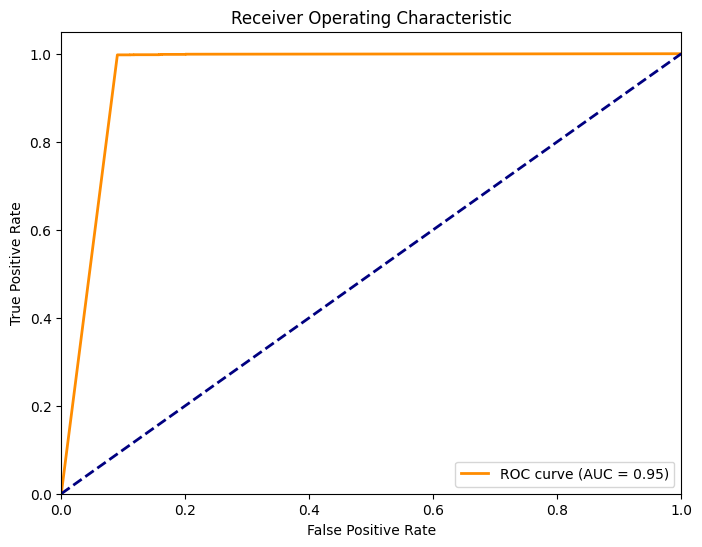

In [ ]:
train_and_evaluate_model_randomized('KNN', X_train, y_train, X_test, y_test)


# Logistic Regression with hyperparameter tuning and RandomSearchCV

Confusion Matrix:
[[9900 2125]
 [2628 9301]]
Model: Logistic Regression
Accuracy: 0.80
Recall: 0.78
Precision: 0.81
F1 Score: 0.80


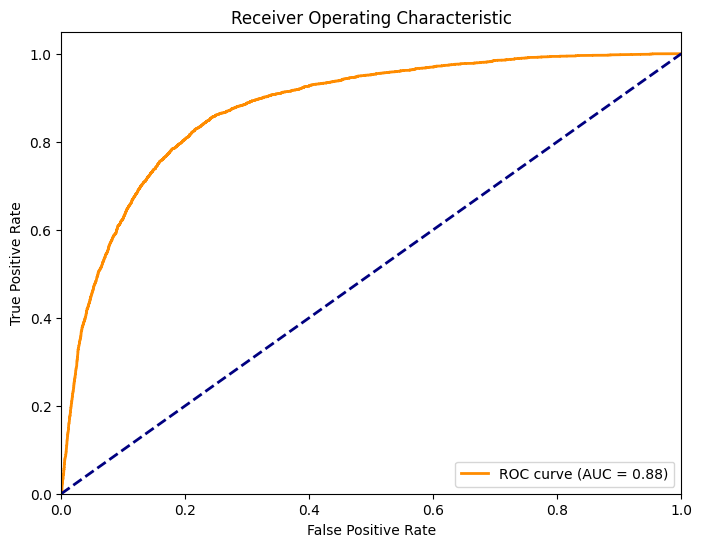

In [ ]:
train_and_evaluate_model_randomized('Logistic Regression', X_train, y_train, X_test, y_test)


# Decision Tree with hyperparameter tuning and RandomSearchCV

Confusion Matrix:
[[10831  1194]
 [   29 11900]]
Model: Decision Tree
Accuracy: 0.95
Recall: 1.00
Precision: 0.91
F1 Score: 0.95


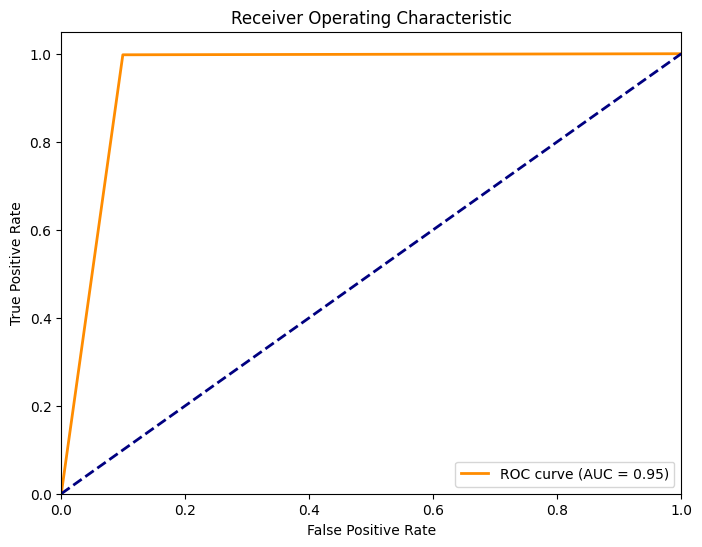

In [ ]:
train_and_evaluate_model_randomized('Decision Tree', X_train, y_train, X_test, y_test)


# Random Forest with hyperparameter tuning and RandomSearchCV

Confusion Matrix:
[[11115   910]
 [   21 11908]]
Model: Random Forest
Accuracy: 0.96
Recall: 1.00
Precision: 0.93
F1 Score: 0.96


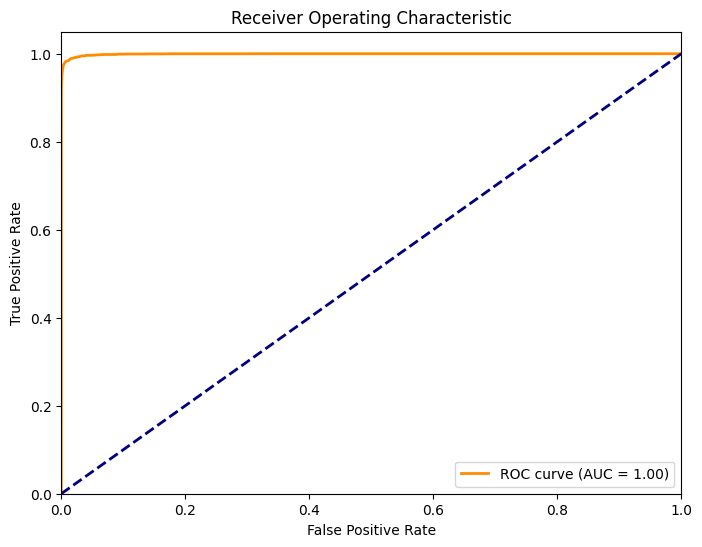

In [ ]:
train_and_evaluate_model_randomized('Random Forest', X_train, y_train, X_test, y_test)


# XGBoost with hyperparameter tuning and RandomSearchCV

Confusion Matrix:
[[10388  1637]
 [  558 11371]]
Model: XGBoost
Accuracy: 0.91
Recall: 0.95
Precision: 0.87
F1 Score: 0.91


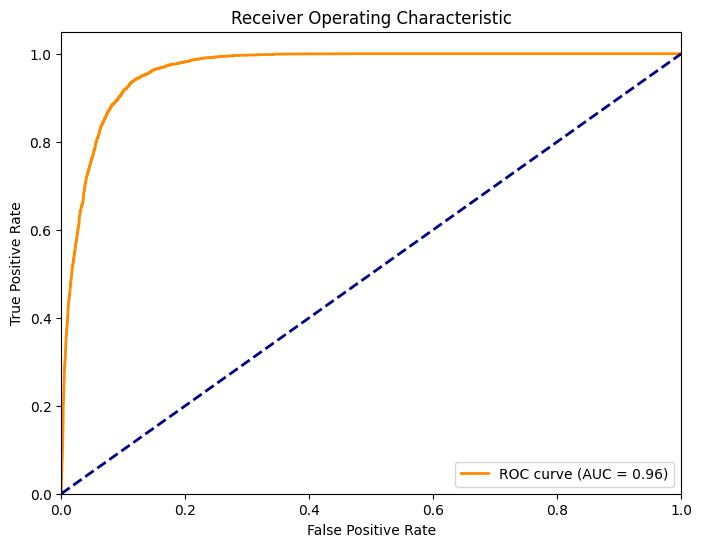

In [ ]:
train_and_evaluate_model_randomized('XGBoost', X_train, y_train, X_test, y_test)


# Conclusion

After evaluating accuracy scores, recall, precision, and F1 score using both GridSearchCV and RandomSearchCV, the clear choice for the best-performing model is Random Forest. It achieves an impressive F1 score and boasts a high accuracy rate of 96%.

This model excels in identifying all genuine positive cases. Moreover, its precision, which is close to 1, indicates that when it predicts a positive outcome, it's highly likely to be accurate.

An AUC value of 1 signifies that the Receiver Operating Characteristic (ROC) curve exhibits a flawless vertical alignment, indicating that the model attains a true positive rate of 100% while simultaneously maintaining a false positive rate of 0% across all conceivable classification thresholds. The occurrence of flawless discrimination is an infrequent and extraordinary circumstance.

Although achieving an AUC of 1 is theoretically feasible, it is uncommon to attain such a flawless AUC in practical applications.

The Random Forest model achieved a remarkable AUC of 1.0, indicating an almost perfect predictive performance on the training data. However, it's crucial to note that such high AUC values may suggest the presence of overfitting, where the model has learned the training data too well and may not generalize effectively to new data.

As a measure of robustness and to mitigate potential overfitting, we also trained an **XGBoost model**, which delivered a strong ROC score of 0.96. This demonstrates that XGBoost provides a high level of predictive accuracy while reducing the risk of overfitting. Therefore, we recommend considering the XGBoost model for predictions on new data, as it strikes a balance between predictive power and generalization to unseen data.

These findings underscore the importance of assessing model performance not only through high training scores but also through their ability to perform well on unseen data, which is a critical aspect of any successful predictive modeling project.

# Business Summary: Optimizing Direct Marketing Campaigns for a Portuguese Banking Institution

In today's competitive financial landscape, success depends on reaching and engaging the right customers effectively. This project aims to assist a prominent Portuguese banking institution in optimizing its direct marketing campaigns, specifically related to term deposit subscriptions. By leveraging predictive modeling and data analysis, the bank can enhance campaign efficiency and success by targeting potential subscribers more effectively.

### Key Insights:
Job Categories: The analysis reveals distinct patterns in subscription rates across job categories. Management roles and students exhibit higher subscription rates, while blue-collar workers have a lower conversion rate. The bank should prioritize targeting and engaging blue-collar workers to improve conversion rates.

Marital Status: Married customers have a notably lower conversion rate compared to single customers. There is an opportunity to develop targeted strategies to enhance the conversion rate among married customers.

Education Levels: Customers with tertiary education are more likely to subscribe to deposits. Tailoring marketing and educational strategies to reach a broader audience with higher education levels can lead to higher subscription rates.

Financial Stability: Customers without defaulted loans, housing loans, and personal loans are more likely to subscribe to deposits. Targeting individuals with a good credit score and a positive financial outlook can lead to improved results.

Contact Method: Customers contacted via cellular communication are more likely to subscribe compared to those contacted via telephone.

Previous Campaign Outcome: Customers with a successful outcome in the previous campaign are significantly more likely to subscribe to term deposits. Success in prior campaigns positively impacts the current campaign's success.


### Targeted Approach:
To enhance campaign success, the bank should tailor its strategies to specific customer segments with the following characteristics:
•	Job Categories: Emphasize specific job categories with higher subscription likelihood.
•	Education: Target customers with higher education levels.
•	Contact Method: Focus on customers contacted through effective communication channels.
•	Financial Stability: Prioritize customers without loans.
•	Previous Campaign Outcome: Engage customers who had a successful outcome in prior campaigns.


### Model Selection:
After rigorous evaluation, the Random Forest model stands out as the best-performing model, achieving a high F1 score and accuracy of 96%. However, the XGBoost model also provides strong performance while reducing the risk of overfitting, making it a viable option for predictions on new data


### Conclusion:
In a highly competitive banking sector, optimizing direct marketing campaigns is essential for success. By understanding the nuanced preferences and behaviors of different customer segments and deploying advanced predictive models, the bank can maximize the chances of customer subscription to term deposits and achieve its campaign goals. This data-driven approach ensures not only short-term success but also long-term customer satisfaction and loyalty, setting the stage for sustainable growth and profitability.

In [ ]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler


df=pd.read_csv()

X = df.drop('Y',axis=1)
y = df['Y']



# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

ss = StandardScaler()
X_train_scale = ss.fit_transform(X_train)
X_test_scale = ss.transform(X_test)


# Logistic Regression (Use Logistic Regression for classification)
logistic_model = LogisticRegression()
logistic_model.fit(X_train_scale, y_train)

# K-Nearest Neighbors
knn_model = KNeighborsClassifier()
knn_model.fit(X_train_scale, y_train)

# Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(X_train_scale, y_train)

# XGBoost
xgb_model = XGBClassifier()
xgb_model.fit(X_train_scale, y_train)

# Decision Tree
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train_scale, y_train)

# Evaluate models on the test set
models = {
    'Logistic Regression': logistic_model,
    'KNN': knn_model,
    'Random Forest': rf_model,
    'XGBoost': xgb_model,
    'Decision Tree': dt_model,
}

for model_name, model in models.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    
    print(f"\n\nEvaluation for {model_name}:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"Classification Report:\n{report}")
    print(f"Classification Report:\n{report}")
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Print the confusion matrix
    print("Confusion Matrix:")
    print(conf_matrix)
    
  
    

In [ ]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load Breast Cancer dataset
df=pd.read_csv()

X = df.drop('Y',axis=1)
y = df['Y']


# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train the linear regression model
linear_model = LinearRegression()
linear_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = linear_model.predict(X_test_scaled)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")
